In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

#Functions

In [ ]:
def calcPSNR(sImage, fImage):
  if sImage.shape != fImage.shape:
    print("Images must be of same dimensions!")
    return -1
  s1, s2, s3 = cv2.split(sImage)
  f1, f2, f3 = cv2.split(fImage)
  e1 = np.sum(np.square(s1 - f1))
  e2 = np.sum(np.square(s2 - f2))
  e3 = np.sum(np.square(s3 - f3))
  MSE = (1/(sImage.shape[0]*sImage.shape[1]*3)) * (e1+e2+e3)
  return 10*np.log10(255/MSE)

In [ ]:
def bgrToYuv(inImg):
  B = inImg[:,:,0]
  G = inImg[:,:,1]
  R = inImg[:,:,2]
  Y = 0.299*R + 0.587*G + 0.114*B
  U = 0.492*(B-Y) + 128
  V = 0.877*(R-Y) + 128
  return np.stack((Y.astype(dtype = "uint8"), U.astype(dtype = "uint8"), V.astype(dtype = "uint8")), axis=2)

In [ ]:
def yuvToBgr(inImg):
  Y = inImg[:,:,0]
  U = inImg[:,:,1]
  V = inImg[:,:,2]
  R = Y + 1.140 * (V) + 113
  G = Y - 0.395*(U) - 0.581*(V) + 125
  B = Y + 2.032*(U)
  return np.stack((B.astype(dtype = "uint8"), G.astype(dtype = "uint8"), R.astype(dtype = "uint8")), axis=2)

In [ ]:
def encode(orig, factor):
  addW, addH = 0, 0
  while((orig.shape[0] % factor) != 0):
    pad = np.zeros((1, orig.shape[1]), dtype=int)
    orig = np.append(orig, pad, axis=0)
    addH += 1
  while((orig.shape[1] % factor) != 0):
    pad = np.zeros((orig.shape[0], 1), dtype=int)
    orig = np.append(orig, pad, axis=1)
    addW += 1
  #Optionally use gaussian or simple averaging kernel before downsampling
  # filtImg = conv(orig, avgFilt, pad=1)
  return orig[::factor, ::factor]

#installTens


In [ ]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.7/489.7 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow
    Foun

#TensImports

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

#ModelDefinition

In [ ]:
def get_model_y():
  input = Input(shape=(None, None, 1))
  norm_inp = input/255
  x = Conv2D(32, 3, activation='relu', padding='same')(norm_inp)
  x = Conv2D(64, 3, activation='relu', padding='same')(x)
  x = UpSampling2D(2, interpolation='bilinear')(x)
  x = Conv2D(64, 3, activation='relu', padding='same')(x)
  x = Conv2D(32, 3, activation='relu', padding='same')(x)
  x = Conv2D(1, 3, activation=None, padding='same')(x)
  x = Activation('tanh')(x)
  x = x*127.5 + 127.5
  model = Model([input], x)
  model.summary()
  return model

model = get_model_y()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, None, None, 1)    0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    320       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 up_sampling2d (UpSampling2D  (None, None, None, 64)   0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 64)    36928 

In [ ]:
def get_model_uv():
  input = Input(shape=(None, None, 1))
  norm_inp = input/255
  x = Conv2D(32, 3, activation='relu', padding='same')(norm_inp)
  x = Conv2D(64, 3, activation='relu', padding='same')(x)
  x = Conv2D(128, 3, activation='relu', padding='same')(x)
  x = UpSampling2D(4)(x)
  x = Conv2D(64, 3, activation='relu', padding='same')(x)
  x = Conv2D(32, 3, activation='relu', padding='same')(x)
  x = Conv2D(1, 3, activation=None, padding='same')(x)
  x = Activation('tanh')(x)
  x = x*127.5 + 127.5
  model = Model([input], x)
  model.summary()
  return model

model_uv = get_model_uv()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, None, None, 1)    0         
 da)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 32)    320       
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 128)   73856     
                                                                 
 up_sampling2d_1 (UpSampling  (None, None, None, 128)  0         
 2D)                                                       

#GeneratingData


In [ ]:
def get_data_y():
  x = []
  y = []
  for dir in tqdm(glob('/content/drive/MyDrive/compeng4dn4_project/database/*.png')):
    im = cv2.imread(dir)
    im_yuv = bgrToYuv(im)
    y_ch = im_yuv[:,:,0]
    y_out = cv2.resize(y_ch, (512,512), interpolation=cv2.INTER_AREA)
    y_in = encode(y_out, 2)
    x.append(y_in)
    y.append(y_out)
  x = np.array(x)
  y = np.array(y)
  return x, y

In [ ]:
def get_data_u():
  x = []
  y = []
  for dir in tqdm(glob('/content/drive/MyDrive/compeng4dn4_project/database/*.png')):
    im = cv2.imread(dir)
    im_yuv = bgrToYuv(im)
    u_ch = im_yuv[:,:,1]
    u_out = cv2.resize(u_ch, (512,512), interpolation=cv2.INTER_AREA)
    u_in = encode(u_out, 4)
    x.append(u_in)
    y.append(u_out)
  x = np.array(x)
  y = np.array(y)
  return x, y

In [ ]:
def get_data_v():
  x = []
  y = []
  for dir in tqdm(glob('/content/drive/MyDrive/compeng4dn4_project/database/*.png')):
    im = cv2.imread(dir)
    im_yuv = bgrToYuv(im)
    v_ch = im_yuv[:,:,2]
    v_out = cv2.resize(v_ch, (512,512), interpolation=cv2.INTER_AREA)
    v_in = encode(v_out, 4)
    x.append(v_in)
    y.append(v_out)
  x = np.array(x)
  y = np.array(y)
  return x, y

#Fitting Models

In [ ]:
modelY = get_model_y()

x, y = get_data_y()

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=400)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = 'mae'
modelY.compile(loss=loss, optimizer=optimizer)

save_model_callback= tf.keras.callbacks.ModelCheckpoint(
    'model/modelY.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch')

tbCallback = tf.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

batch_size = 4
epochs = 20
modelY.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=tbCallback)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, None, None, 1)    0         
 da)                                                             
                                                                 
 conv2d_28 (Conv2D)          (None, None, None, 32)    320       
                                                                 
 conv2d_29 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 up_sampling2d_5 (UpSampling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 conv2d_30 (Conv2D)          (None, None, None, 64)    3692

100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


Epoch 1/20
18/18 [==============================] - 4s 130ms/step - loss: 46.4640 - val_loss: 27.4222
Epoch 2/20
18/18 [==============================] - 2s 120ms/step - loss: 25.7049 - val_loss: 27.0336
Epoch 3/20
18/18 [==============================] - 2s 119ms/step - loss: 18.1283 - val_loss: 16.2288
Epoch 4/20
18/18 [==============================] - 2s 119ms/step - loss: 13.5119 - val_loss: 14.6178
Epoch 5/20
18/18 [==============================] - 2s 119ms/step - loss: 10.6863 - val_loss: 11.3809
Epoch 6/20
18/18 [==============================] - 2s 119ms/step - loss: 10.8255 - val_loss: 12.3414
Epoch 7/20
18/18 [==============================] - 2s 119ms/step - loss: 10.0247 - val_loss: 11.6521
Epoch 8/20
18/18 [==============================] - 2s 120ms/step - loss: 8.7217 - val_loss: 10.0565
Epoch 9/20
18/18 [==============================] - 2s 122ms/step - loss: 8.1710 - val_loss: 9.9282
Epoch 10/20
18/18 [==============================] - 2s 121ms/step - loss: 8.5179 - v

In [ ]:
modelU = get_model_uv()

x, y = get_data_u()

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=400)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = 'mse'
modelU.compile(loss=loss, optimizer=optimizer)

save_model_callback= tf.keras.callbacks.ModelCheckpoint(
    'model/modelU.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch')

tbCallback = tf.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

batch_size = 4
epochs = 15
modelU.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=tbCallback)


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, None, None, 1)    0         
 da)                                                             
                                                                 
 conv2d_33 (Conv2D)          (None, None, None, 32)    320       
                                                                 
 conv2d_34 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 conv2d_35 (Conv2D)          (None, None, None, 128)   73856     
                                                                 
 up_sampling2d_6 (UpSampling  (None, None, None, 128)  0         
 2D)                                                       

100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Epoch 1/15
18/18 [==============================] - 5s 169ms/step - loss: 312.6021 - val_loss: 280.6927
Epoch 2/15
18/18 [==============================] - 3s 159ms/step - loss: 306.2797 - val_loss: 279.0452
Epoch 3/15
18/18 [==============================] - 3s 159ms/step - loss: 303.5795 - val_loss: 275.8925
Epoch 4/15
18/18 [==============================] - 3s 161ms/step - loss: 293.4037 - val_loss: 258.3186
Epoch 5/15
18/18 [==============================] - 3s 163ms/step - loss: 286.4107 - val_loss: 241.7035
Epoch 6/15
18/18 [==============================] - 3s 160ms/step - loss: 251.9170 - val_loss: 214.9630
Epoch 7/15
18/18 [==============================] - 3s 165ms/step - loss: 184.1407 - val_loss: 144.2732
Epoch 8/15
18/18 [==============================] - 3s 161ms/step - loss: 104.4011 - val_loss: 98.2548
Epoch 9/15
18/18 [==============================] - 3s 165ms/step - loss: 64.5190 - val_loss: 81.0941
Epoch 10/15
18/18 [==============================] - 3s 161ms/step 

In [ ]:
modelV = get_model_uv()

x, y = get_data_v()

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=400)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = 'mse'
modelV.compile(loss=loss, optimizer=optimizer)

save_model_callback= tf.keras.callbacks.ModelCheckpoint(
    'model/modelV.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch')

tbCallback = tf.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

batch_size = 4
epochs = 15
modelV.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=tbCallback)


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, None, None, 1)    0         
 da)                                                             
                                                                 
 conv2d_39 (Conv2D)          (None, None, None, 32)    320       
                                                                 
 conv2d_40 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 conv2d_41 (Conv2D)          (None, None, None, 128)   73856     
                                                                 
 up_sampling2d_7 (UpSampling  (None, None, None, 128)  0         
 2D)                                                       

100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


Epoch 1/15
18/18 [==============================] - 3s 163ms/step - loss: 440.5229 - val_loss: 436.3975
Epoch 2/15
18/18 [==============================] - 3s 157ms/step - loss: 432.3522 - val_loss: 431.3467
Epoch 3/15
18/18 [==============================] - 3s 161ms/step - loss: 423.5068 - val_loss: 412.4966
Epoch 4/15
18/18 [==============================] - 3s 163ms/step - loss: 402.0478 - val_loss: 386.2869
Epoch 5/15
18/18 [==============================] - 3s 163ms/step - loss: 376.3829 - val_loss: 352.1669
Epoch 6/15
18/18 [==============================] - 3s 159ms/step - loss: 312.4050 - val_loss: 272.1153
Epoch 7/15
18/18 [==============================] - 3s 164ms/step - loss: 216.7014 - val_loss: 158.1606
Epoch 8/15
18/18 [==============================] - 3s 165ms/step - loss: 118.7227 - val_loss: 93.0303
Epoch 9/15
18/18 [==============================] - 3s 166ms/step - loss: 72.4618 - val_loss: 71.5584
Epoch 10/15
18/18 [==============================] - 3s 168ms/step 

In [ ]:
import os
if not os.path.exists('./models'):
    os.makedirs('./models')

modelY.save('./models/model/modelY_e3_mae.h5')

In [ ]:
def convolve2d(image, kernel):
    m, n = image.shape
    km, kn = kernel.shape
    pad_width = ((km//2, km//2), (kn//2, kn//2))
    image = np.pad(image, pad_width, mode='constant')
    res = np.zeros((m, n))
    kernel = np.flipud(np.fliplr(kernel))
    for i in range(m):
        for j in range(n):
            res[i, j] = np.sum(kernel * image[i:i+km, j:j+kn])
    return res

def calculate_ssim(img1, img2, K1, K2, window_size):
    img1 = img1/ 255
    img2 = img2 / 255
    C1 = (K1 * 255) ** 2
    C2 = (K2 * 255) ** 2
    kern = np.ones((window_size, window_size))
    mu1 = convolve2d(img1, kern) / (window_size ** 2)
    mu2 = convolve2d(img2, kern) / (window_size ** 2)
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = convolve2d(img1 ** 2, kern) / (window_size ** 2) - mu1_sq
    sigma2_sq = convolve2d(img2 ** 2, kern) / (window_size ** 2) - mu2_sq
    sigma12 = convolve2d(img1 * img2, kern) / (window_size ** 2) - mu1_mu2
    return np.mean(((2 * mu1_mu2 + C1) * (2 * sigma12 + C2))/((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)))

#LoadInImage

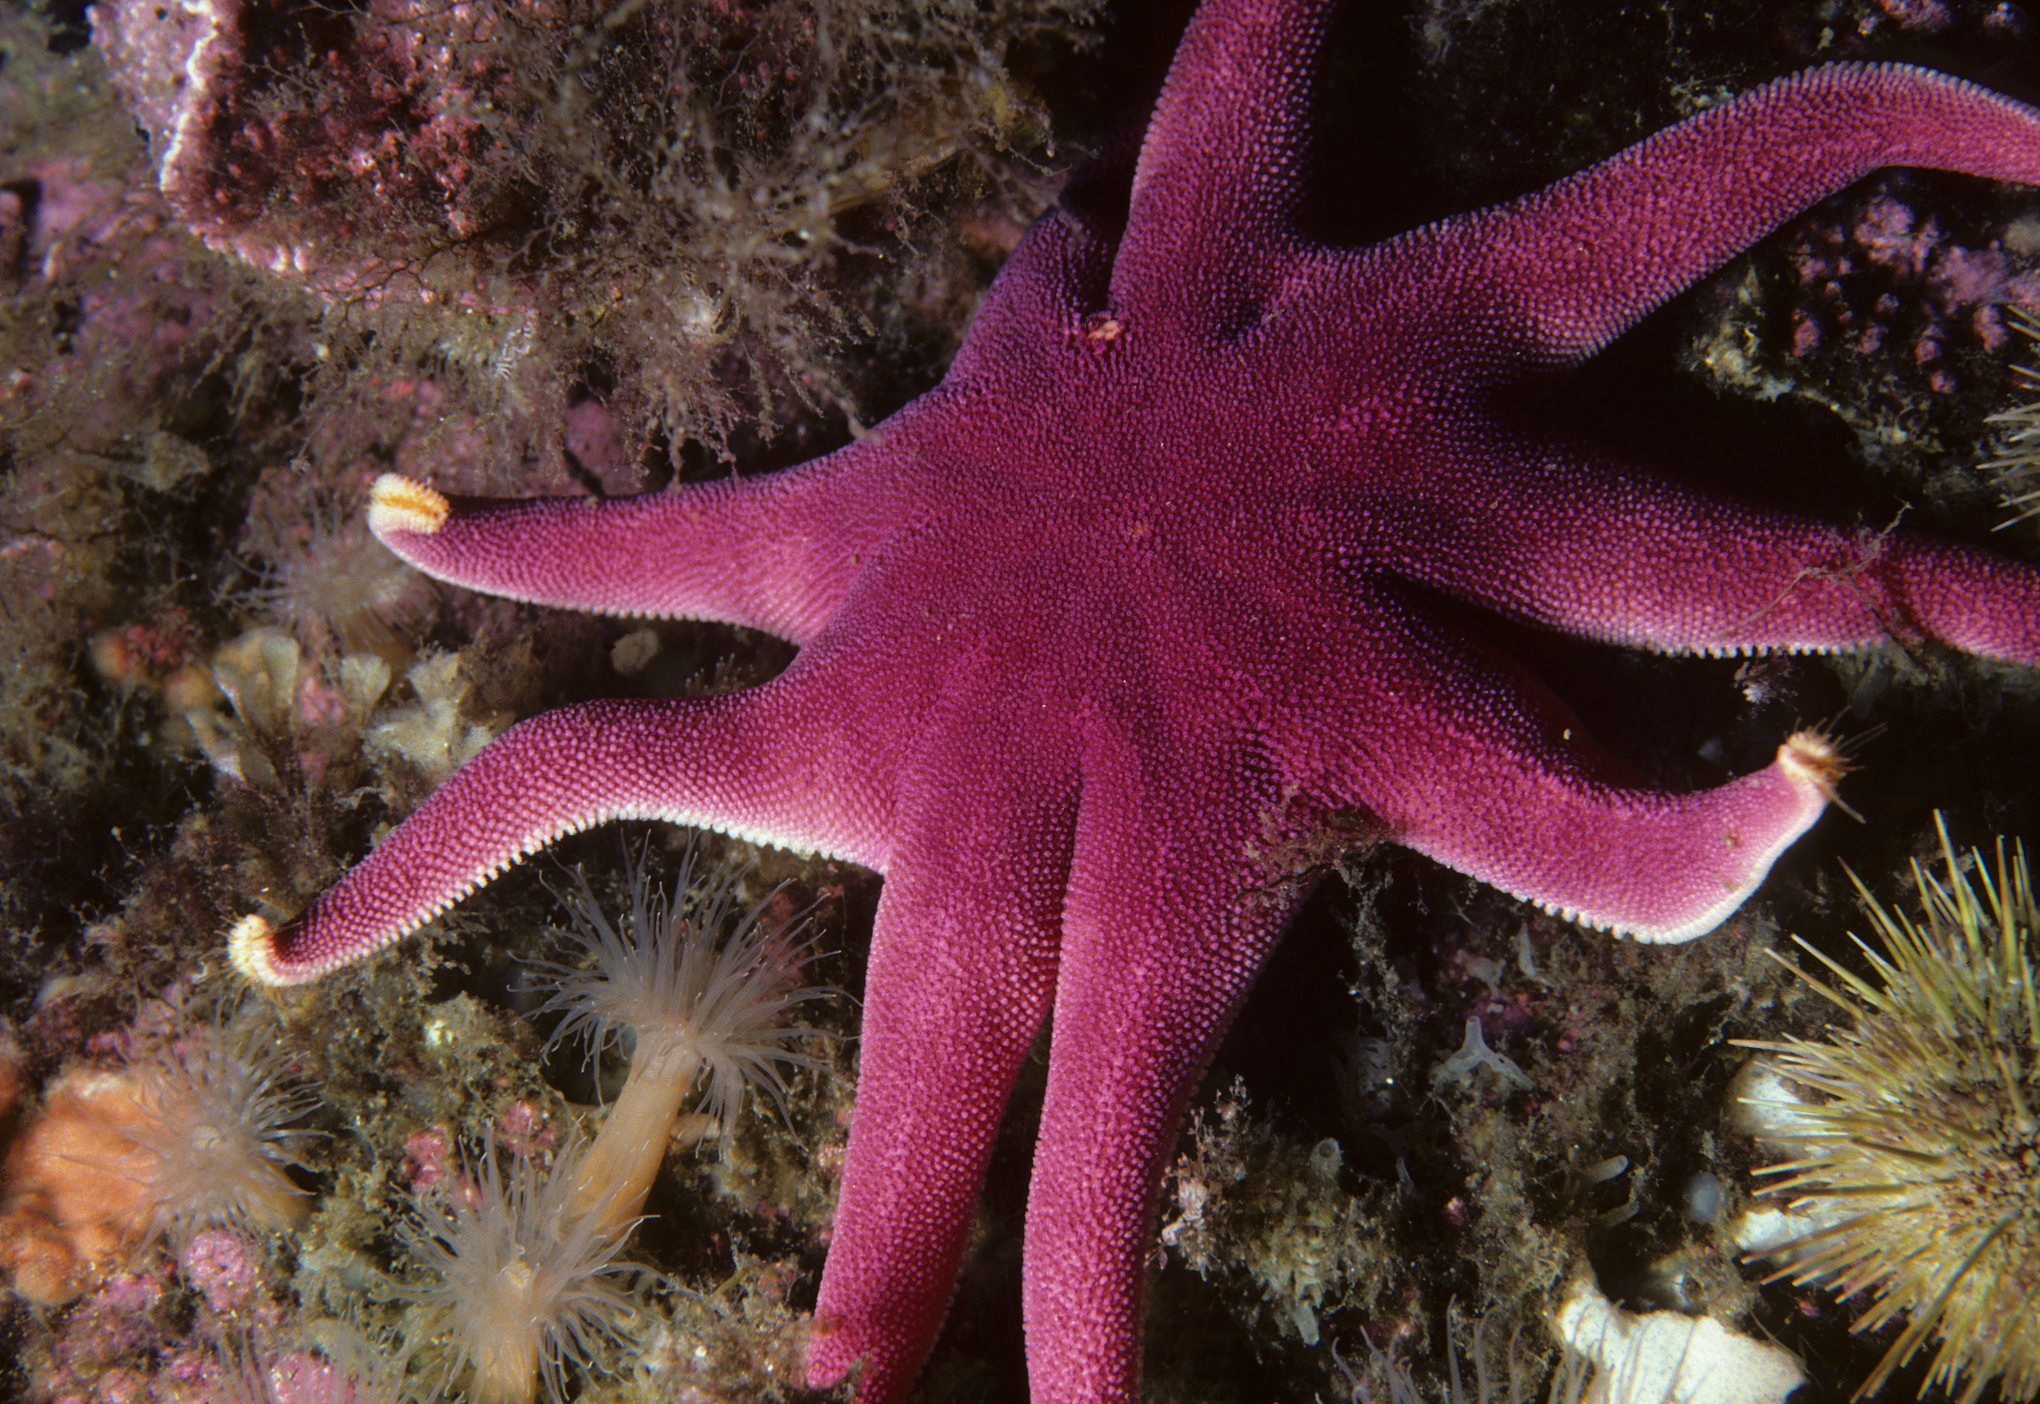

In [ ]:
img_path = r'/content/drive/MyDrive/compeng4dn4_project/database/0001.png'
orig_img = cv2.imread(img_path)
cv2_imshow(orig_img)

#Running Pipeline

In [ ]:
def encDec(path):

  orig_img = cv2.imread(path)
  img_res = cv2.imread(path)
  # img_res = cv2.resize(orig_img, (1024,1024), interpolation=cv2.INTER_AREA)
  # cv2_imshow(img_res)

  imgYUV = bgrToYuv(img_res)

  yEnc = encode(imgYUV[:,:,0], 2)
  uEnc = encode(imgYUV[:,:,1], 4)
  vEnc = encode(imgYUV[:,:,2], 4)

  #predict Y
  x_y = np.reshape(yEnc, (1, yEnc.shape[0], yEnc.shape[1], 1))
  y_ups = modelY.predict(x_y)
  y_ups = np.squeeze(y_ups, axis=0)
  #predict U
  x_u = np.reshape(uEnc, (1, uEnc.shape[0], uEnc.shape[1], 1))
  u_ups = modelU.predict(x_u)
  u_ups = np.squeeze(u_ups, axis=0)
  #predict V
  x_v = np.reshape(vEnc, (1, vEnc.shape[0], vEnc.shape[1], 1))
  v_ups = modelV.predict(x_v)
  v_ups = np.squeeze(v_ups, axis=0)

  #convert back to BGR
  reImage = np.stack((y_ups[:,:,0].astype(dtype = "uint8"), u_ups[:,:,0].astype(dtype = "uint8"), v_ups[:,:,0].astype(dtype = "uint8")),axis=2)
  img = yuvToBgr(reImage)
  # cv2_imshow(img)

  # g_orig = cv2.cvtColor(img_res, cv2.COLOR_BGR2GRAY)
  # g_rec = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


  print('Original Image')
  cv2_imshow(img_res)
  print('Reconstructed Image')
  cv2_imshow(img)



  print(f'The PSNR value is: {calcPSNR(img_res, img)} and the SSIM is {calculate_ssim(imgYUV[:,:,0], y_ups[:,:,0], K1=0.01, K2=0.03, window_size=8)}')


#Making Predicitons

******************************Image test1******************************
Original Image


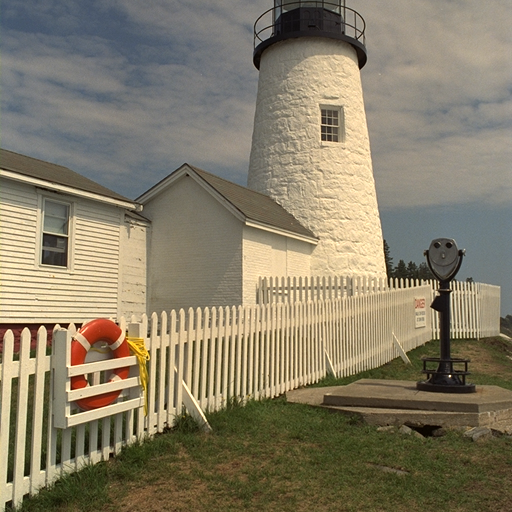

Reconstructed Image


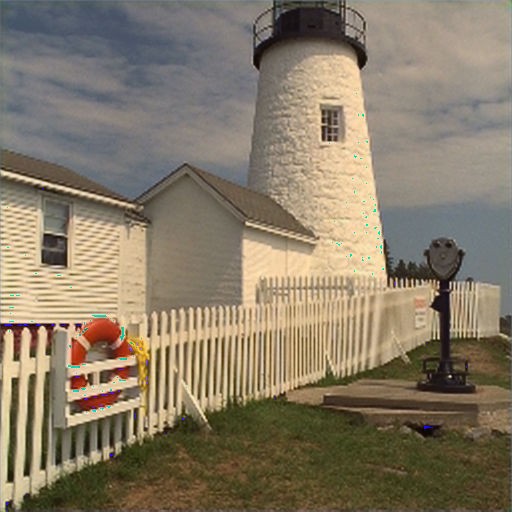

The PSNR value is: 8.131179977974249 and the SSIM is 0.9999341654987347
**********************************************************************
******************************Image test2******************************
Original Image


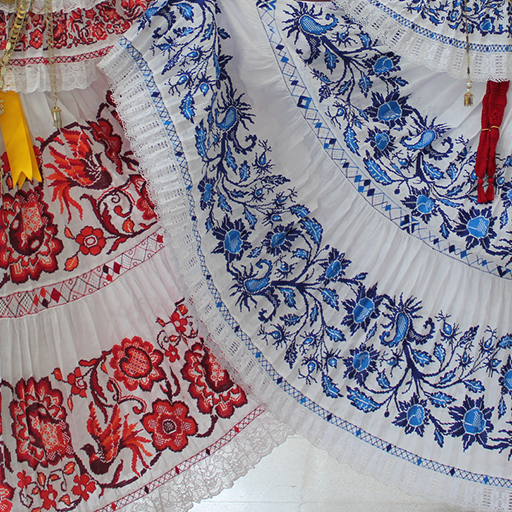

Reconstructed Image


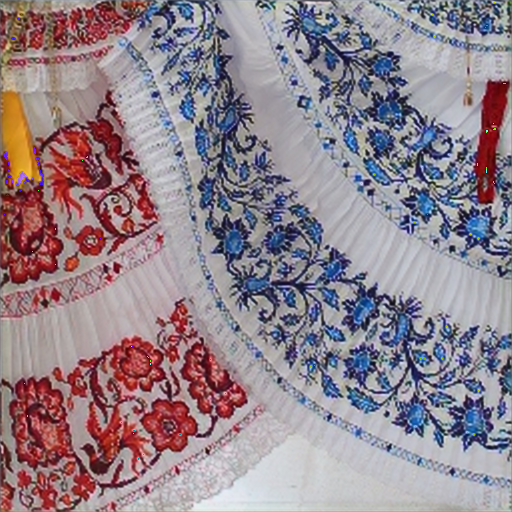

The PSNR value is: 5.973023448270749 and the SSIM is 0.9998478710462381
**********************************************************************


In [ ]:
a = ['test1', 'test2']
for num in a:
  print(30*'*' + f'Image {num}' + 30*'*')
  img_path = f'/content/drive/MyDrive/compeng4dn4_project/testImages/{num}.png'
  encDec(img_path)
  print(70*'*')
